In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import IBMQ, pulse
from qiskit.tools import job_monitor

## Find a backend

In [2]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-research', group='tokyo-1', project='main')
backend = provider.get_backend('ibmq_armonk')

## Define the parameters of the experiment

In [3]:
# Length of one AWG time sample
dt = backend.configuration().dt
# SX pulse of qubit 0 calibrated by IBM
sx_pulse = backend.defaults().instruction_schedule_map.get('sx', [0]).instructions[0][1].pulse
# Frequency offset to use
frequency_offset = 0.1e+9
# Angle points
angles = np.linspace(0., np.pi, 20)

## Create pulse schedules

In [4]:
schedules = []

for angle in angles:
    with pulse.build(backend=backend, default_alignment='sequential') as sched:
        # Drive channel for qubit 0
        d0 = pulse.drive_channel(0)
        
        # pi/2 rotation about the X axis (state on to the Y axis)
        pulse.play(sx_pulse, d0)
        
        # Shift the LO frequency and wait
        #  Angular frequency offset: omega = 2pi * offset
        #  Phase accumulated per clock: dphi = omega * dt
        #  => Delay by (angle / dphi) clocks is equivalent to Rz(angle)
        with pulse.frequency_offset(frequency_offset, d0):
            pulse.delay(int(angle / (2. * np.pi * frequency_offset * dt)), d0)
            
        # Another pi/2 rotation about the X axis
        pulse.play(sx_pulse, d0)

        # Projective measurement in Z basis
        pulse.measure(qubits=[0], registers=[pulse.MemorySlot(0)])

    schedules.append(sched)

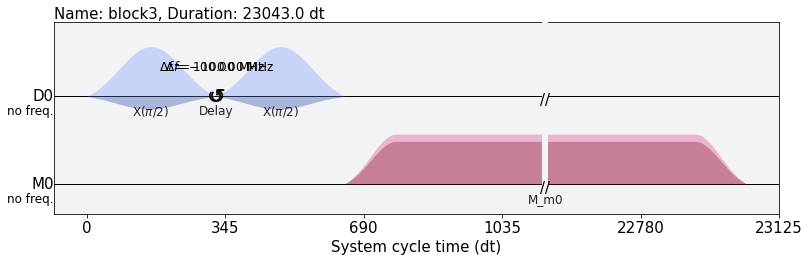

In [5]:
schedules[3].draw()

## Submit the job and evaluate the result

In [6]:
job = backend.run(schedules, shots=8192)
job_monitor(job)
counts = job.result().get_counts()

Job Status: job has successfully run


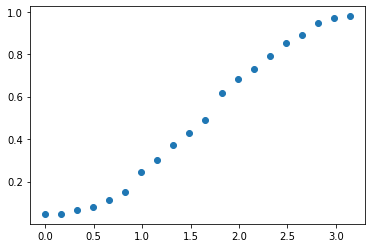

In [7]:
# Probability of observing 0 at each Rz angle
yval = np.array([c.get('0', 0) / sum(c.values()) for c in counts])

plt.scatter(angles, yval)